In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SSM-V4

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SSM-V4


# **Setting Up the Environment for Image Processing**
---
In this section of the notebook, we are preparing our environment for processing images, particularly for the task of converting image masks into bounding boxes suitable for YOLO (You Only Look Once) model training. The key libraries we are importing include:

* **os**: This module provides a way of using operating system dependent
functionality. We'll use it to handle file paths and directory operations.
* **cv2 (OpenCV)**: An open-source computer vision and machine learning software library. It's instrumental in image processing tasks.
* **numpy**: A library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays. It's crucial for handling image data.
* **glob**: This module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell. It's useful for loading the dataset.
* **tqdm**: A library that provides a fast, extensible progress bar for loops and iterations. We're importing tqdm.notebook which provides a Jupyter notebook optimized progress bar, and also the standard tqdm for other uses.
* **PIL (Python Imaging Library)**: This library adds image processing capabilities to your Python interpreter. We're using it for opening, manipulating, and saving many different image file formats.
---
This setup is essential for ensuring we have all the necessary tools and functionalities to proceed with converting image masks into YOLO format bounding boxes.

The process involves reading image files, processing them, and ultimately extracting valuable information that can be used to train object detection models.

In [ ]:
from PIL import Image
from PIL import Image, ImageDraw, ImageFont
from tqdm.notebook import tqdm
from tqdm import tqdm
import os
import cv2
import numpy as np
from glob import glob

### **Resizing and Saving Images**
---
This section of the code is dedicated to resizing images from a source directory and saving the resized versions to a target directory.

This operation is crucial for standardizing the image sizes before processing or training machine learning models. Here's a step-by-step explanation:

- **Create Target Directory:** First, we ensure that the target directory where the resized images will be saved exists. If it doesn't, it's created using `os.makedirs()`. This step prevents errors that would occur if we attempted to save files to a non-existent directory.

- **Iterate Over Images:** We loop through each file in the source directory. The loop only processes files that end with `.jpg`, which are standard JPEG image files. This filtering ensures we're only working with images.

- **Open and Optionally Resize the Image:** Each image is opened using the PIL library. Resizing is typically done to normalize the dimensions of the images, which can be critical for certain machine learning or image processing tasks.

- **Save the Resized Image:** Finally, the opened (and potentially resized) image is saved to the target directory. The filename remains unchanged, ensuring the resized image retains its original name for consistency and traceability.

This function is a template for basic image processing tasks, allowing for customization such as different resizing options or processing other image formats.

---

This approach keeps the comments concise and focuses on explaining the core functionality of the code, while the text cell provides a more detailed narrative suitable for educational purposes or for documentation.

In [ ]:
def resize_images(source_dir, target_dir):

    """
    Resizes images from the source directory and saves them to the target directory.

    Parameters:
    - source_dir (str): The path to the directory containing the original images.
    - target_dir (str): The path to the directory where the resized images will be saved.
    """
    # Ensure the target directory exists
    os.makedirs(target_dir, exist_ok=True)

    # Iterate over all files in the source directory. The tqdm function adds a progress
    # bar to indicate the process of resizing images.
    for filename in tqdm(os.listdir(source_dir), desc="Resizing images"):

        # Check if the file is a .jpg
        if filename.lower().endswith('.jpg'):

            # Construct the full path to the image by joining the source directory and the filename.
            image_path = os.path.join(source_dir, filename)

            # Open the image using PIL's Image.open method.
            img = Image.open(image_path)

            # # Resize the image
            # img_resized = img.resize(size, Image.ANTIALIAS)

            # Save the resized image to the target directory
            img.save(os.path.join(target_dir, filename))

In [ ]:
# Specify the directory containing the original training images
source_directory = 'FloodNet-Supervised_v2.0/train/train-org-img'

# Specify the target directory for the resized images
target_directory = 'FloodNet-Supervised_v3.0/train/images'

In [ ]:
# Call the resize_images function with the source and target directories
resize_images(source_directory, target_directory)

Resizing images: 100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


In [ ]:
# Update the source directory to the validation images directory
source_directory = 'FloodNet-Supervised_v2.0/val/val-org-img'

# Update the target directory to the destination for resized validation images
target_directory = 'FloodNet-Supervised_v3.0/val/images'

In [ ]:
# Execute the resizing function for the validation dataset
resize_images(source_directory, target_directory)

Resizing images: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


In [ ]:
# Define the source directory for test images
source_directory = 'FloodNet-Supervised_v2.0/test/test-org-img'

# Define the target directory where the resized test images will be saved
target_directory = 'FloodNet-Supervised_v3.0/test/images'

In [ ]:
# Call the resize_images function to process and save the resized test images
resize_images(source_directory, target_directory)

Resizing images: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


### **Converting Segmentation Masks to YOLO Format**
---
The process of training YOLO (You Only Look Once) models for object detection requires labels in a specific format. Each object in an image is represented by a line in the corresponding label file, containing the object class ID and the bounding box coordinates. The bounding box is specified by the center coordinates (x, y), along with the width (w) and height (h) of the box. All these values are normalized to the range [0, 1] relative to the image size.

The `convert_to_yolo_format` function plays a crucial role in this preparation process by converting segmentation masks, which typically delineate the object by coloring pixels belonging to the object, into the YOLO label format. This conversion involves the following steps:

1. **Finding Contours:** The function begins by identifying the contours of objects within the binary mask. Each contour corresponds to the boundary of an object in the mask.

2. **Calculating Bounding Boxes:** For each contour found, a bounding box that tightly encloses the contour is calculated. This box is represented by its top-left corner (x, y) coordinates, along with its width (w) and height (h).

3. **Skipping Small Boxes:** To avoid noise and very small objects that may not be relevant or could be detrimental to model training, bounding boxes with a width or height less than 3 pixels are ignored.

4. **Formatting for YOLO:** The bounding box coordinates are then normalized by the dimensions of the original image and formatted into a string that follows the YOLO label format: `"class_id center_x center_y width height"`. The center coordinates, width, and height are all normalized to fall within the range [0, 1].
---
This function is essential for converting pixel-level segmentation annotations into the format required for training YOLO object detection models, facilitating the use of segmentation datasets for object detection tasks.

In [ ]:
def convert_to_yolo_format(mask, class_id, image_shape):

  """
    Converts a binary mask to YOLO format bounding boxes.

    This function finds contours in the given binary mask, calculates bounding
    boxes for these contours, and formats them into the YOLO format. YOLO format
    consists of the class ID followed by the normalized center coordinates, width,
    and height of each bounding box. Small boxes (width or height less than 3 pixels)
    are skipped to avoid noise.

    Parameters:
    - mask (np.ndarray): A binary mask for a specific class, with pixels belonging to the
      class set to 255 and all other pixels set to 0.
    - class_id (int): The class ID for objects in the mask.
    - image_shape (tuple): The shape of the original image as (height, width), used to
      normalize bounding box dimensions.

    Output:
    - boxes (list of str): A list of strings, each representing a bounding box in YOLO
      format: "class_id center_x center_y width height", with all values normalized
      to be within [0, 1].

    Returns:
    - A list of bounding boxes in YOLO format for the given binary mask.
    """

    # Use cv2.findContours to find the contours in the mask.
    # cv2.RETR_EXTERNAL retrieves only the extreme outer contours,
    # and cv2.CHAIN_APPROX_SIMPLE compresses horizontal, vertical, and diagonal segments
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize an empty list to store the bounding box information for each contour
    boxes = []

    # Iterate over each contour found in the mask
    for contour in contours:

        # Calculate the bounding rectangle for each contour, which gives us the x, y coordinates, and the width (w) and height (h)
        x, y, w, h = cv2.boundingRect(contour)

        # Skip contours that result in small bounding boxes (less than 3 pixels in either dimension)
        if w < 3 or h < 3:
            continue

        # Format the bounding box information in YOLO format and append it to the boxes list.
        # YOLO format: class_id center_x center_y width height, with all values normalized to [0, 1] by dividing by image dimensions.
        boxes.append(
            f"{class_id} {(x + w / 2) / image_shape[1]} {(y + h / 2) / image_shape[0]} {w / image_shape[1]} {h / image_shape[0]}"
        )
    return boxes

### **Converting Segmentation Masks to YOLO Format Labels**
---
This function, `masks_to_yolo_labels`, takes segmentation masks stored as images and converts them into YOLO format labels. This conversion is essential for training YOLO models, which require object bounding boxes as input rather than pixel-wise masks. Here's a breakdown of its key steps:

1. **Directory Preparation:** The function first ensures that the output directory for the YOLO labels exists, creating it if necessary.
2. **Processing Each Mask:** It iterates through each mask image in the specified directory. These masks are read in grayscale to simplify the process of identifying different objects/classes.
3. **Class Iteration and Box Extraction:** For each class present in the dataset, the function generates a binary mask that isolates pixels belonging to that class. It then calls `convert_to_yolo_format`, which converts these binary masks into YOLO format bounding boxes.
4. **Saving Labels:** Finally, it saves the YOLO format labels to a `.txt` file with the same name as the mask image (excluding the '_lab' part, if present). Each line in this file represents a bounding box for an object in the image.
---
This conversion process is crucial for using segmentation datasets with object detection models like YOLO, enabling the models to learn from pixel-level annotations.

In [ ]:
def masks_to_yolo_labels(masks_dir, labels_dir):

    """
    Converts segmentation masks into YOLO format labels and saves them to the specified directory.

    Parameters:
    - masks_dir (str): The path to the directory containing the segmentation mask images.
    - labels_dir (str): The path to the directory where the YOLO format labels will be saved.
    - n_classes (int): The number of unique classes in the segmentation masks, including the background if applicable.

    Output:
    - Saves a .txt file for each mask image in the `labels_dir`, where each file contains the YOLO formatted bounding boxes for the detected classes in the corresponding image.

    """

    # Ensure the labels directory exists
    os.makedirs(labels_dir, exist_ok=True)

    # Process each mask file in the masks directory
    for mask_path in tqdm(glob(os.path.join(masks_dir, "*.png")), desc=f"Converting masks in {masks_dir}"):

        # Read the mask as a grayscale image
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        image_shape = mask.shape
        boxes = []
        # for class_id in range(1, N_CLASSES):  # Assuming class IDs start from 1
        #     binary_mask = (mask == class_id).astype(np.uint8) * 255
        #     boxes.extend(convert_to_yolo_format(binary_mask, class_id-1, image_shape))  # YOLO class IDs are 0-indexed

        # Iterate over each class ID and extract bounding boxes
        for class_id in range(0, N_CLASSES):  # Assuming class IDs start from 0
            binary_mask = (mask == class_id).astype(np.uint8) * 255

            # Convert segmentation mask to YOLO format bounding boxes
            boxes.extend(convert_to_yolo_format(binary_mask, class_id, image_shape))

        # Write boxes to file
        # label_file = os.path.join(labels_dir, os.path.splitext(os.path.basename(mask_path))[0] + ".txt")

        # Save the YOLO format labels to a text file
        label_file = os.path.join(labels_dir, os.path.splitext(os.path.basename(mask_path))[0].replace('_lab', '') + ".txt")
        with open(label_file, 'w') as f:
            for box in boxes:
                f.write(box + "\n")

In [ ]:
# Define a list of class names that the model will learn to identify. The first class is typically reserved for the background.
class_names = [
    'background', 'Building-flooded', 'Building-non-flooded',
    'Road-flooded', 'Road-non-flooded', 'Water',
    'Tree', 'Vehicle', 'Pool', 'Grass'
]

# Calculate the number of classes based on the length of the class_names list.
N_CLASSES = len(class_names)

In [ ]:
# Paths to datasets
train_masks_dir = "FloodNet-Supervised_v2.0/train/train-label-img"
val_masks_dir = "FloodNet-Supervised_v2.0/val/val-label-img"
test_masks_dir = "FloodNet-Supervised_v2.0/test/test-label-img"

In [ ]:
# Output directories for YOLO labels
train_labels_dir = "FloodNet-Supervised_v3.0/train/labels"
val_labels_dir = "FloodNet-Supervised_v3.0/val/labels"
test_labels_dir = "FloodNet-Supervised_v3.0/test/labels"

In [ ]:
masks_to_yolo_labels(train_masks_dir, train_labels_dir)
masks_to_yolo_labels(val_masks_dir, val_labels_dir)
masks_to_yolo_labels(test_masks_dir, test_labels_dir)

Converting masks in FloodNet-Supervised_v2.0/train/train-label-img:   0%|          | 0/100 [00:00<?, ?it/s]

Converting masks in FloodNet-Supervised_v2.0/val/val-label-img:   0%|          | 0/15 [00:00<?, ?it/s]

Converting masks in FloodNet-Supervised_v2.0/test/test-label-img:   0%|          | 0/15 [00:00<?, ?it/s]

### **Use the color specified for each class to draw the box**
---
These colors are defined in RGB format, where each tuple contains three values representing the Red, Green, and Blue components of the color, respectively. The values range from 0 to 255.

This setup allows for easy differentiation between the various classes when visualizing the results of your object detection or segmentation tasks.

In [ ]:
class_colors = [
    (255, 0, 0),   # Red for 'background'
    (0, 255, 0),   # Green for 'Building-flooded'
    (0, 0, 255),   # Blue for 'Building-non-flooded'
    (255, 255, 0), # Cyan for 'Road-flooded'
    (0, 255, 255), # Yellow for 'Road-non-flooded'
    (255, 0, 255), # Magenta for 'Water'
    (192, 192, 192), # Grey for 'Tree'
    (128, 0, 0),     # Maroon for 'Vehicle'
    (128, 128, 0),   # Olive for 'Pool'
    (0, 128, 0)      # Dark Green for 'Grass'
]

### Visualizing Object Detection Results
---
To understand the performance of our object detection model, visualizing the predicted bounding boxes on the images is crucial. The `draw_boxes_with_labels` function is designed for this purpose. It reads an image and the associated label file containing bounding boxes in YOLO format, then draws these boxes on the image along with the class labels.

**Steps Performed by the Function:**

1. **Open the Image:** The input image is opened, and a drawing context is created to allow annotations.

2. **Load Bounding Box Data:** It reads the label file, where each line corresponds to a detected object and contains the class ID and bounding box coordinates in the YOLO format (normalized to the range [0, 1]).

3. **Draw Each Bounding Box:** For each object, it calculates the pixel coordinates of the bounding box from the normalized YOLO format. It then draws the rectangle using a color specific to the object's class.

4. **Label the Boxes:** Under each bounding box, the class name is displayed. This provides a clear visual cue for what the model has detected.

5. **Save the Annotated Image:** Finally, the annotated image is saved to the specified output path. This image now serves as a visual reference to assess the model's detection capabilities.
---
**Practical Use:**

This visualization technique is not only helpful for evaluating the accuracy and precision of your model's predictions but also essential for presentations, reports, or simply to get a quick glance at the detection results.

In [ ]:
def draw_boxes_with_labels(image_path, label_file_path, output_path):
    """
    Draws bounding boxes with class labels on an image and saves the result.

    Parameters:
    - image_path (str): Path to the input image.
    - label_file_path (str): Path to the label file containing bounding box coordinates in YOLO format.
    - output_path (str): Path where the output image with drawn boxes will be saved.

    Output:
    - An image with bounding boxes and class labels drawn on it, saved to `output_path`.
    """
    # Open the input image
    image = Image.open(image_path)
    # Create a drawing context
    draw = ImageDraw.Draw(image)
    # Get image dimensions
    width, height = image.size

    # Read bounding box data from the label file
    with open(label_file_path, 'r') as file:
        boxes = file.readlines()

    # Iterate over each bounding box
    for box in boxes:
        # Parse the box parameters and convert them from YOLO format to pixel coordinates
        class_id, x_center, y_center, w, h = map(float, box.split())
        x_center, y_center, w, h = x_center * width, y_center * height, w * width, h * height
        x_min, y_min = int(x_center - w / 2), int(y_center - h / 2)
        x_max, y_max = int(x_center + w / 2), int(y_center + h / 2)

        # Choose a color for the bounding box based on the class ID
        color = class_colors[int(class_id) % len(class_colors)]
        # Draw the bounding box
        draw.rectangle(((x_min, y_min), (x_max, y_max)), outline=color, width=4)

        # Draw the class name at the bottom of the bounding box
        class_name = class_names[int(class_id) % len(class_names)]
        text_size = draw.textsize(class_name)
        draw.rectangle(((x_min, y_max - text_size[1]), (x_min + text_size[0], y_max)), fill=color)
        draw.text((x_min, y_max - text_size[1]), class_name, fill='black')

    # Save the image with annotations
    image.save(output_path)

In [ ]:
# Assuming the function draw_boxes_with_labels is defined as per the previous instructions,
# and class_names and class_colors are defined and match your dataset classes

# Paths to the image, its YOLO formatted label file, and the desired output path for the annotated image
image_path = 'FloodNet-Supervised_v1.02/test/images/6898.jpg'
label_file_path = 'FloodNet-Supervised_v1.02/test/labels/6898.txt'
output_path = '6898_annotated_image.jpg'

# Call the function to draw bounding boxes and class labels on the image
draw_boxes_with_labels(image_path, label_file_path, output_path)

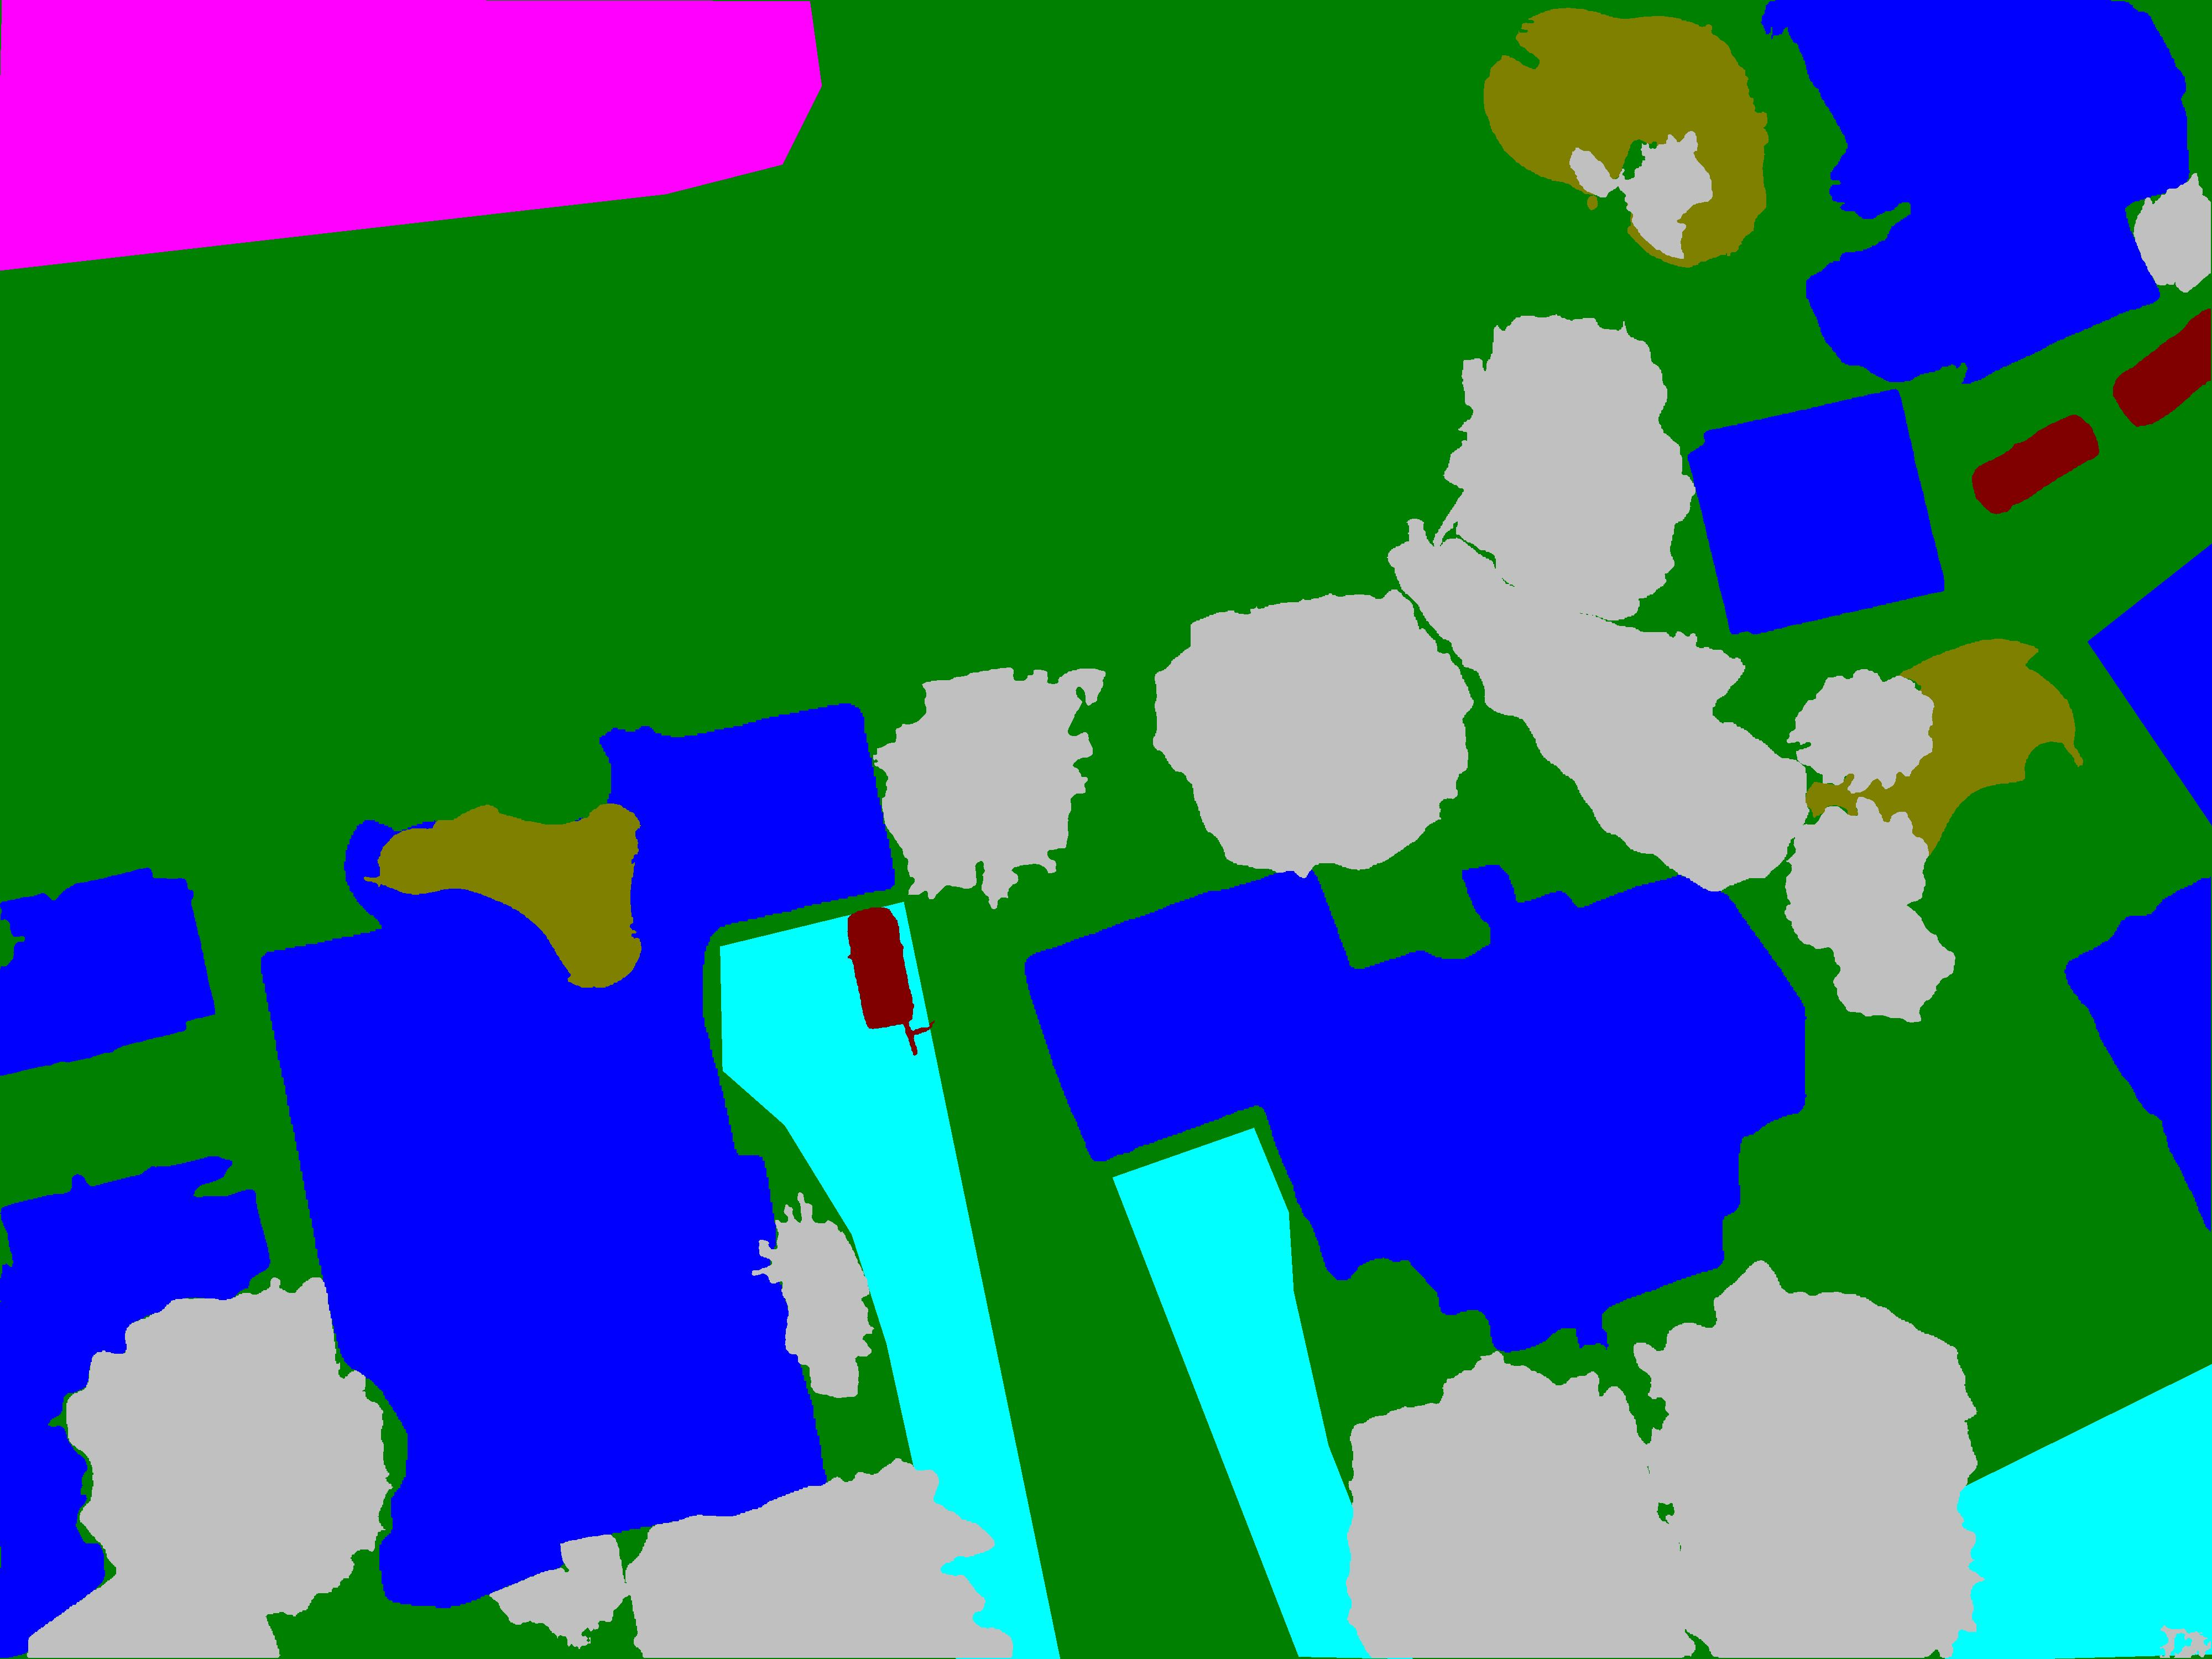

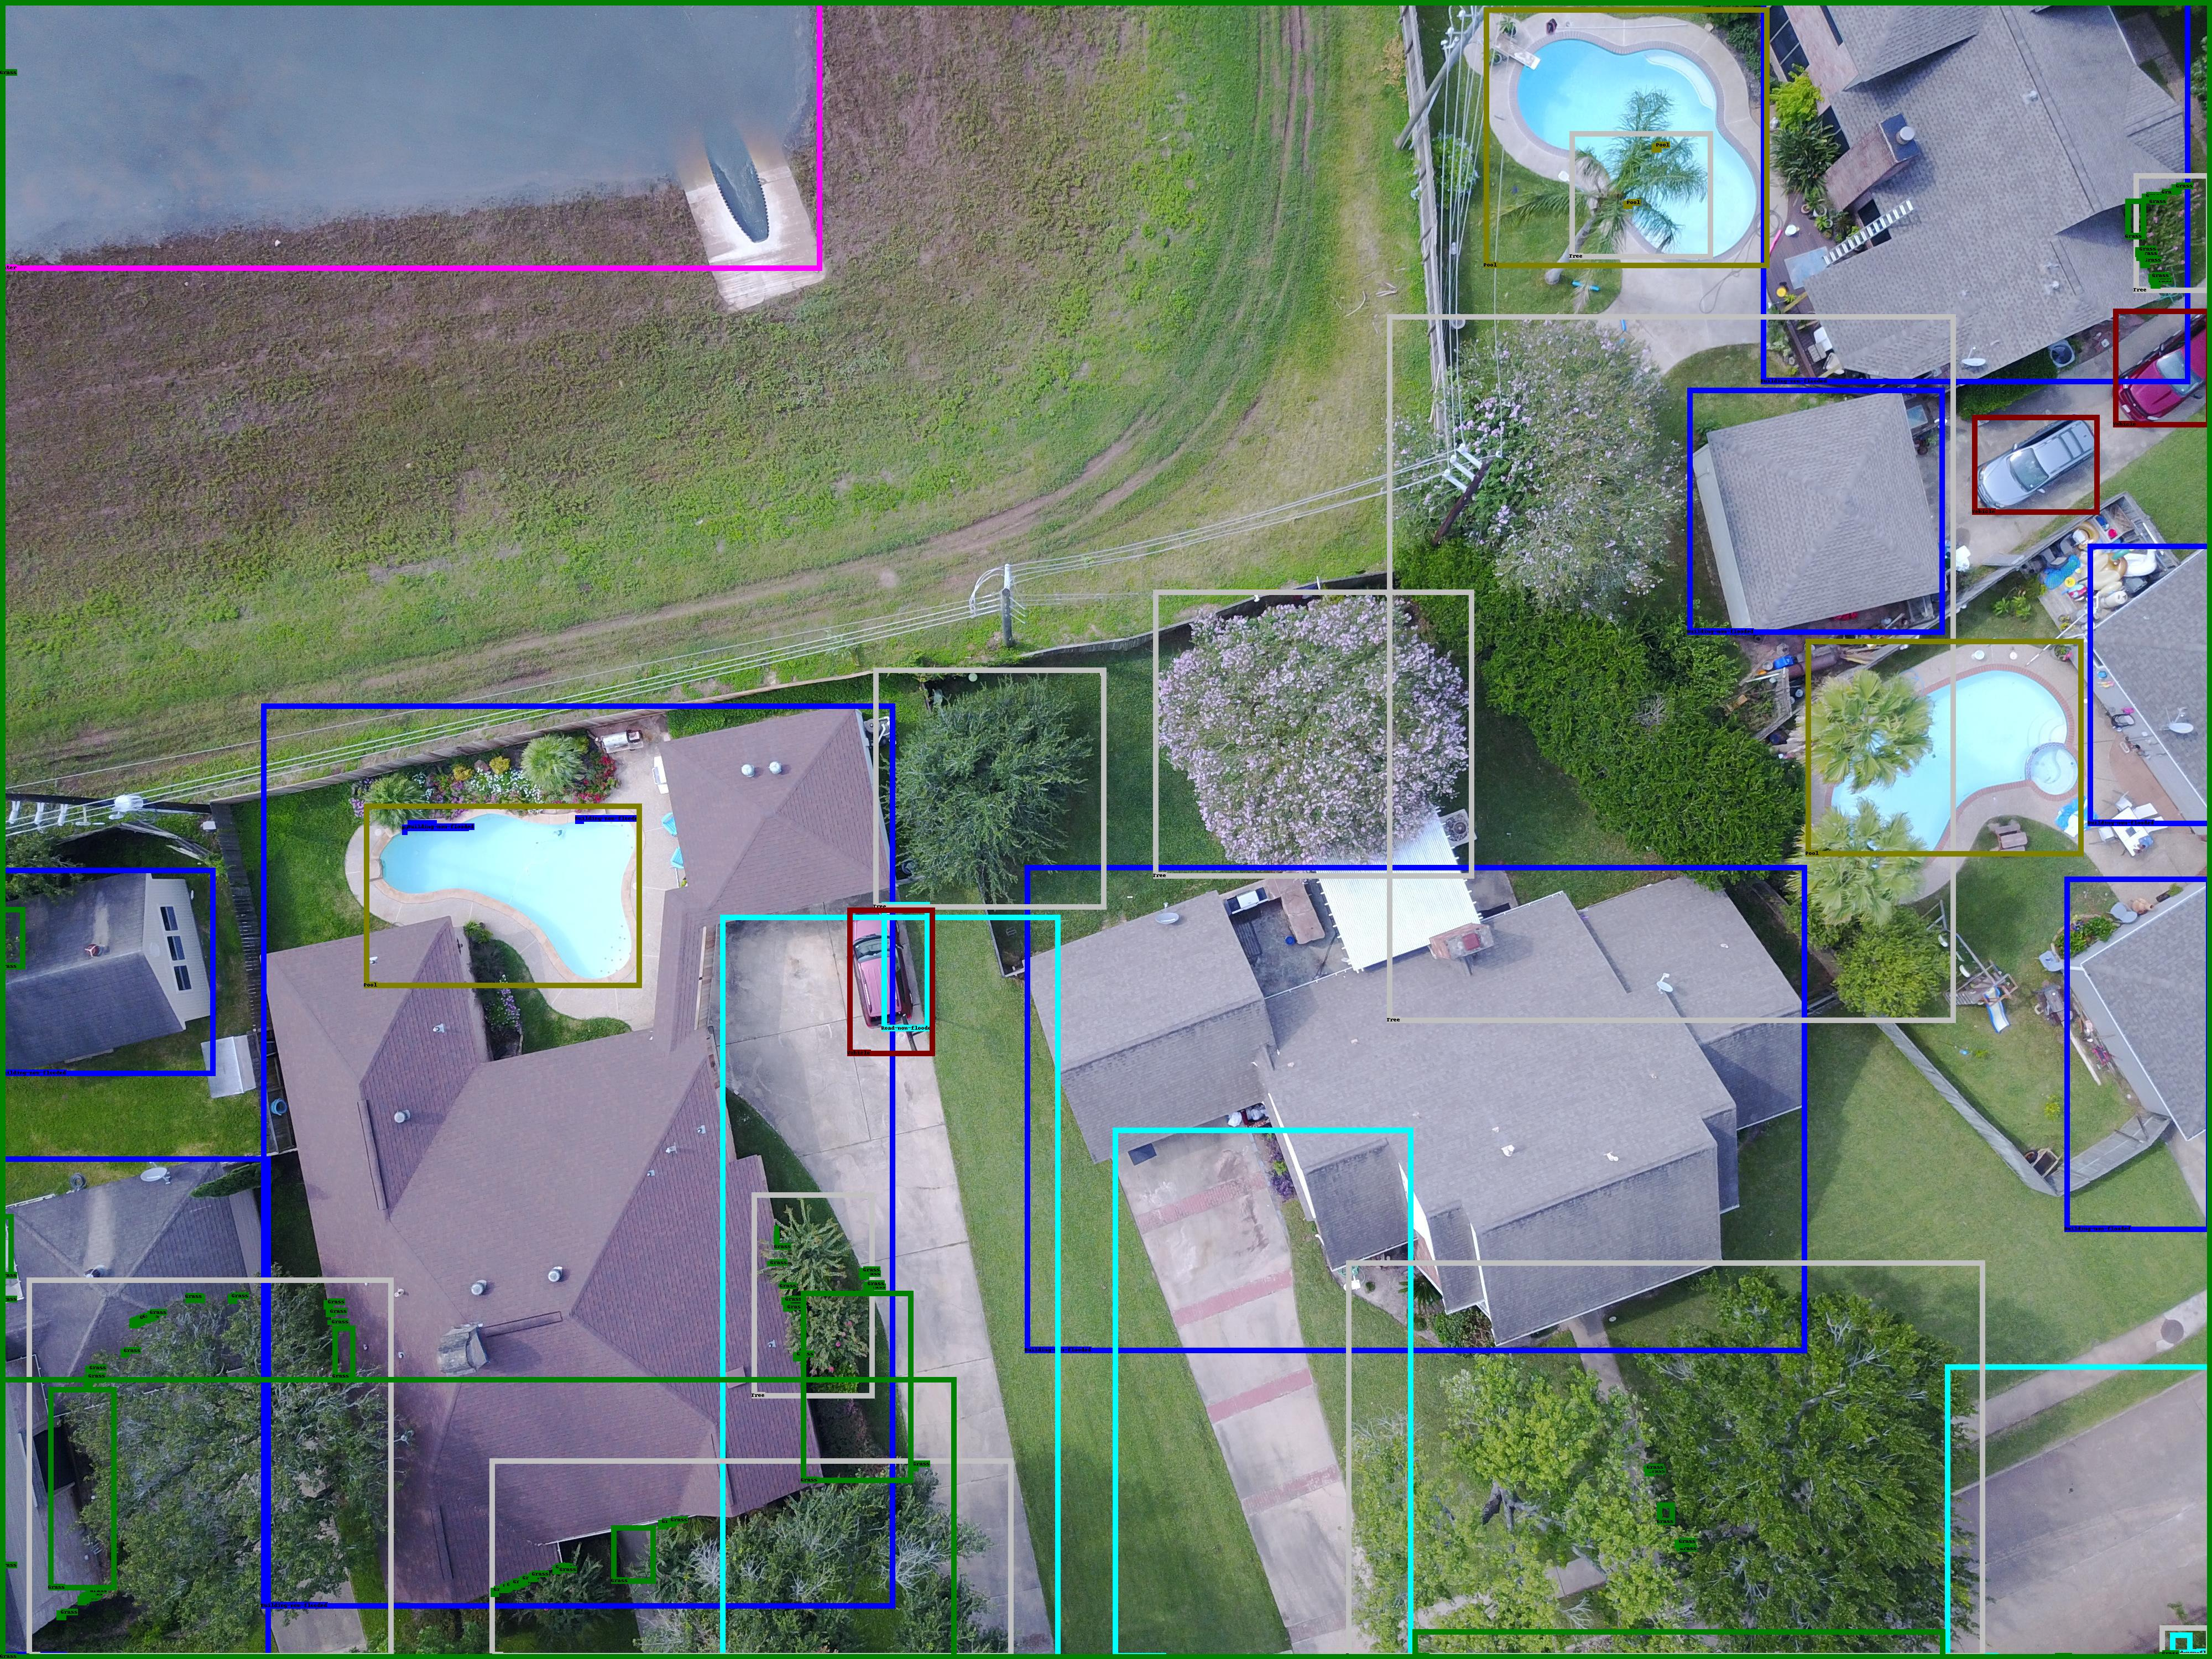